In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.image as mpimg
import PIL
from PIL import Image
import cv2
from scipy import interpolate
from skimage import io, color
from matplotlib.patches import Circle
import sys
sys.path.insert(0, './PythonSIFT')
import pysift
import glob
from scipy.ndimage import rotate
import pandas as pd
import scipy
from scipy.sparse import linalg as lin
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
%matplotlib inline

In [43]:
def plot_img(size, im_list, im_names_list, im_shape):
    if (im_shape[0] == 1 and im_shape[1] == 1):
        fig, ax = plt.subplots(1, 1, figsize = (size[0],size[1]))
        ax.set_title(im_names_list[0])
        ax.imshow(im_list[0])
        ax.set_axis_off()
    else:
        fig, ax = plt.subplots(im_shape[0], im_shape[1], figsize = (size[0],size[1]))
        for j, axs in enumerate(ax.reshape(-1),0):
            axs.set_title(im_names_list[j])
            axs.imshow(im_list[j])
            axs.set_axis_off()
            plt.tight_layout()

In [ ]:
def getPoints_SIFT(im1, im2):
    im1    = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY).astype(np.float32)
    im2    = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY).astype(np.float32)
    
    keypoints1, descriptors1 = pysift.computeKeypointsAndDescriptors(im1)
    keypoints2, descriptors2 = pysift.computeKeypointsAndDescriptors(im2)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    p1 = []   
    p2 = []
    for m in good:
        p1.append(keypoints1[m.queryIdx].pt)
        p2.append(keypoints2[m.trainIdx].pt)
        
    image_matches = cv2.drawMatches((im1*255).astype(np.uint8),keypoints1,(im2*255).astype(np.uint8),keypoints2,good[:],None,
                                   flags=2)
    plt.imshow(image_matches),plt.show()

    p1 = np.array(p1)
    p2 = np.array(p2)
    return p1,p2

In [2]:
def im_resize(img,scale_percent = 50):
    #image resize 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    #make resize with interpolation
    img = cv2.resize(img, dim, cv2.INTER_CUBIC)
    return img

In [40]:
def pl_img_spot(img, points):
    #input: image and identification points
    #define axes and figure to subplots
    fig, ax = plt.subplots(figsize = (10,10))
    #show image 
    ax.imshow(img)
    #sign the identification points
    for point in points.T:
        circ = Circle((point[0], point[1]), 5 , color='red')
        ax.add_patch(circ)
        ax.set_axis_off()
    plt.show()
    plt.tight_layout()

In [35]:
def create_ref(im_path, rec_size, size = 30):
    
    im = cv2.imread(im_path)
    im        = cv2.cvtColor(im.copy(), cv2.COLOR_BGR2RGB )
    im     =    im_resize(im.copy(),30)
    
    p_proj = np.array([[0, rec_size, rec_size, 0],[0, 0, rec_size, rec_size]]).astype(np.float32)
    
    
    %matplotlib qt 
    fig  = plt.figure(figsize=(10,10)) 
    plt.imshow(im)     
    plt.axis('off')
    p1 = fig.ginput(4, timeout = 20)
    plt.close()
    p1 = np.array(p1).astype(np.float32)
    %matplotlib inline
    pl_img_spot(im, p1.T)
    M = cv2.getPerspectiveTransform(p1,p_proj.T)
    
    ref_image = cv2.warpPerspective(im,M,(rec_size,rec_size)).copy()
    
    return ref_image

In [5]:
def warp2book(im1, H, im2, interpolation, colorspace):
    
    #check image colorspace space 
    if (colorspace == 'LAB'):
        im1 = color.rgb2lab(im1)
        im2 = color.rgb2lab(im2)
        im1 = np.asarray(im1)
        im2 = np.asarray(im2)
    elif(colorspace == 'RGB'):
        im1 = np.asarray(im1)
        im2 = np.asarray(im2)
    elif (colorspace != 'RGB'):
        print('error')
        return

    
    warp_im2 = []
    r_ , c_ = im1.shape[:2]
    
    x = np.arange(0, c_ , 1)
    y = np.arange(0, r_ , 1)
    
    im_run      = im1.transpose(2, 0, 1)
    
    
    r2_, c2_    = im2.shape[:2]
    
    pos_warp    = np.indices([c2_,r2_,1]).reshape((3,-1))
    pos    = pos_warp.astype(np.float32)
    pos[2] += 1
    pos = H @ pos
    pos = np.divide(pos ,pos[2])
    xx, yy = np.meshgrid(x, y)
    out_r, out_c, out_ch = im2.shape[:]
    im2_warp = im2.transpose(2, 1, 0)
    for j,im in enumerate(im_run, 0):
        colorval   = im[yy ,xx]
        f = interpolate.interp2d(x, y, colorval, kind=interpolation)
        for i,k in enumerate(pos_warp.T,0):
            if(pos[0,i]<c_ and pos[0,i]>= 0 and pos[1,i] < r_ and pos[1,i] > 0):
                im2_warp[j,k[0],k[1]] = f(pos[0,i], pos[1,i])
    
    im2_warp = im2_warp.transpose(2,1,0)
    if (colorspace == 'LAB'):
        im2_warp = color.lab2rgb(im2_warp)
    return im2_warp

In [6]:
def video_to_image_seq(vid_path, output_path=os.path.join("my_data", "video2", "images")):
    os.makedirs(output_path, exist_ok=True)
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    print("converting video to frames...")
    while success:
        fname = str(count).zfill(4)
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        count += 1
    print("total frames: ", count)

In [7]:
def imageimport(img_dir,size):
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        im = Image.open(f1)
        im.resize((size, size))
        data.append(im)
    return data

In [8]:
def s_im2pattern(s,rec_size):
    p_proj = np.array([[0, rec_size, rec_size, 0],[0, 0, rec_size, rec_size]]).astype(np.float32)
    r_, c_ = s[0].shape[:2]
    p_1    = np.array([[0, c_-1, c_-1, 0],[0, 0, r_-1, r_-1]]).astype(np.float32)
    s_proj = []
    M = cv2.getPerspectiveTransform(p_1.T,p_proj.T)
    for i in s:
        s_proj.append(cv2.warpPerspective(i,M,(rec_size,rec_size)).copy())
        
    return s_proj

In [9]:
def orb_fun(im1, im2, show = 0):
    img1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
    orb  = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []

    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)


    
    p1 = []   
    p2 = []
    for m in good:
        p1.append(kp1[m.queryIdx].pt)
        p2.append(kp2[m.trainIdx].pt)
    
    if(show == 1):
        im_match = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=0)
        plt.imshow(im_match)
        plt.show()
        
    p1 = np.array(p1)
    p2 = np.array(p2)

    return p1,p2

In [10]:
def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in glob.glob(os.path.join(imgs_path, '*.jpg')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)

In [11]:
def image_seq(lDBZ, bias, output_path=os.path.join("my_data", "video", "images")):
    count = 0
    for i in lDBZ:
        fname = str(count+bias).zfill(4)
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), cv2.cvtColor(np.uint8(i*255), cv2.COLOR_RGB2BGR))  # save frame as JPEG file
        # print('Read a new frame: ', success)
        count += 1
    print("total frames: ", count)

# 3.1 Create reference model
Take a picture of your favourite book front cover (place it within /code/my_data folder). Make sure the book is not occluded, and the image resolution is
reasonable. We want to convert your book to a model template. Use the functions you have created in the last section to project the front cover into the XY
plane. Use your functions to get the books corners and project it to a reasenoble rectangle. The results should look like the following example:

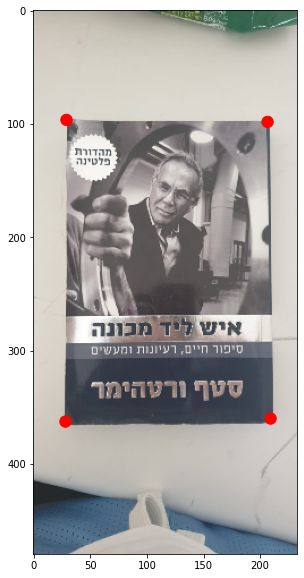

<Figure size 432x288 with 0 Axes>

In [37]:
ref_steff =  create_ref('my_data/books_front/steff.jpeg', 250)

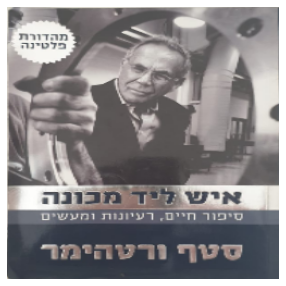

In [46]:
plot_img((5,5), [ref_steff], [''], (1,1))

In [67]:
def im2im(path1, path2, path3, size):
    im3     =    cv2.imread(path3)
    im3     = cv2.cvtColor(im3.copy(), cv2.COLOR_BGR2RGB )
    im3     =    im_resize(im3.copy(),30)
    im1_ref = create_ref(path1, size)
    im2_ref = create_ref(path2, size)
    p_im3, p_im1_ref = getPoints_SIFT(im3.copy(), im1_ref.copy())
    M, _ = cv2.findHomography(p_im3, p_im1_ref, cv2.RANSAC,5.0)
    warp_ref2image = warp2book(im2_ref, M, im3,'cubic','LAB')
    return im1_ref, im2_ref,im3, warp_ref2image

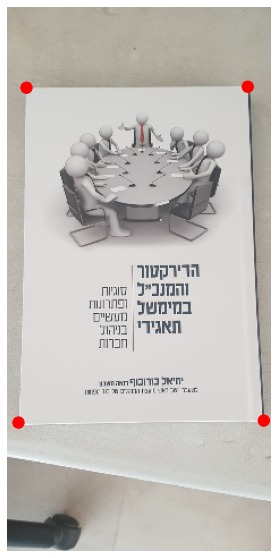

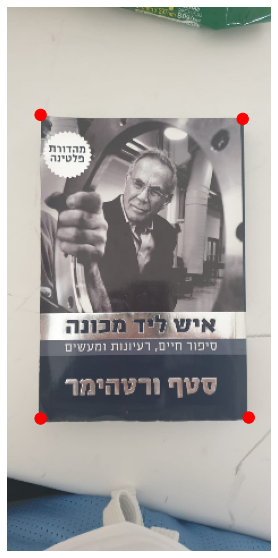

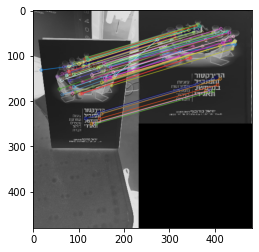

In [68]:
im2warp_path  = 'my_data/books_front/steff.jpeg'
reff_im_path  = 'my_data/books_front/dir2.jpeg'
im2paste_path = 'my_data/books_front/dir.jpeg'
refim1, refim2, im2paste, pasteim = im2im(reff_im_path, im2warp_path, im2paste_path, 250)

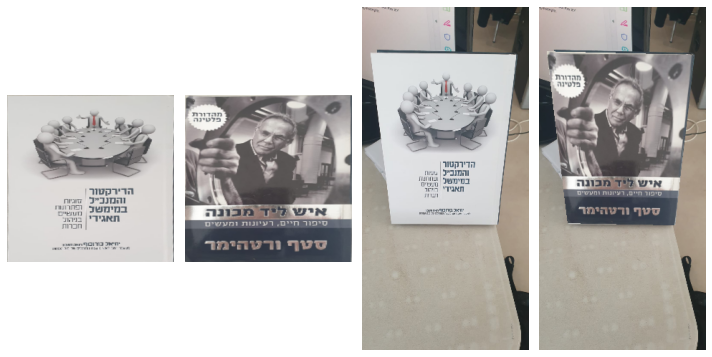

In [82]:
plot_img((10,10), [refim1, refim2 ,im2paste, pasteim],
         ['', '', '', ''], (1, 4))

In [86]:
cv2.imwrite('../output/im2im1.jpg',cv2.cvtColor((pasteim*255).astype(np.uint8),cv2.COLOR_RGB2BGR))

True

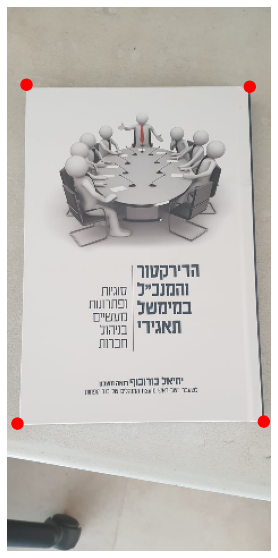

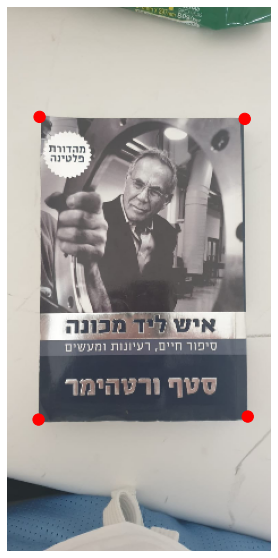

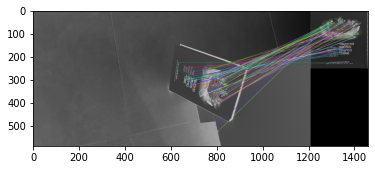

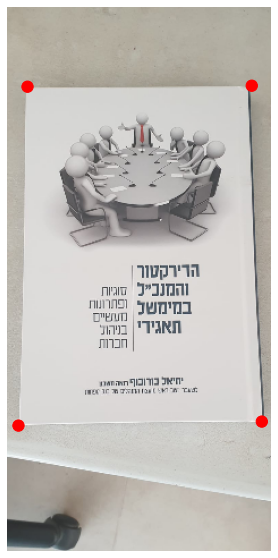

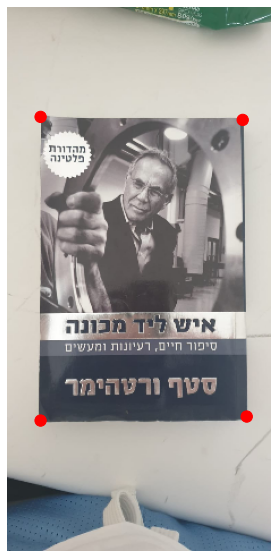

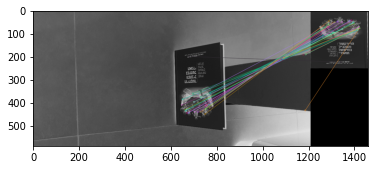

In [89]:
im2paste2_path = 'my_data/books_front/book1.jpg'
im2paste3_path = 'my_data/books_front/book2.jpg'
refim12, refim22, im2paste2, pasteim2 = im2im(reff_im_path, im2warp_path, im2paste2_path, 250)
refim13, refim23, im2paste3, pasteim3 = im2im(reff_im_path, im2warp_path, im2paste3_path, 250)

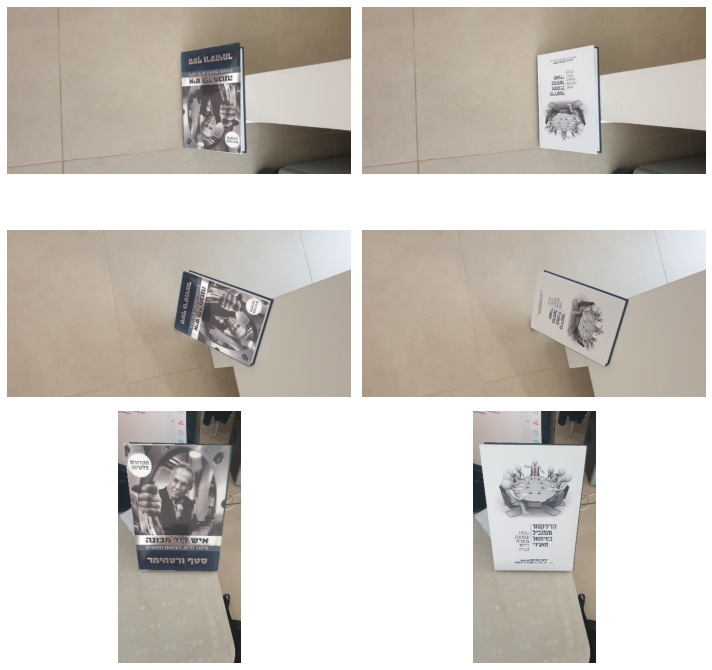

In [93]:
plot_img((10,10), [pasteim3, im2paste3 ,pasteim2, im2paste2, pasteim, im2paste],
         ['', '', '', '', '', ''], (3, 2))

In [94]:
cv2.imwrite('../output/im2im2.jpg',cv2.cvtColor((pasteim2*255).astype(np.uint8),cv2.COLOR_RGB2BGR))
cv2.imwrite('../output/im2im3.jpg',cv2.cvtColor((pasteim3*255).astype(np.uint8),cv2.COLOR_RGB2BGR))

True

# 3.3 Video time
Here you are going to create your Augmented Reality app. You are going to implant a video within another video.
Create a short video (less than 10 sec) of your favorite book, move the book or the camera during the video, and make sure the book is visible within all the
frame. Now, choose another video that you like to implant inside the first one. Your result should be similar to the LifePrint
(https://www.indiegogo.com/projects/lifeprint-photos-that-come-to-life-in-your-hands/#/) project. You'll be given full credits if you can put the video together
correctly. See the following figure for an example frame of what the final video should look like.

In [ ]:
##DBZ video to 


# path = os.path.join("my_data", "video", "Trim_DBZ.mp4")
# video_to_image_seq(path)

##book video to frame

# path_BV = os.path.join("my_data", "video", "book_video.mp4")
# video_to_image_seq(path_BV)

In [95]:
path_DBZ = os.path.join("my_data", "video", "images","DBZ")
dbz_im_s = imageimport(path_DBZ, 240)
path_BV = os.path.join("my_data", "video", "images","BV")
bv_im_s = imageimport(path_BV, 240).copy()

In [72]:
dbz_np = []
for i in dbz_im_s:
    dbz_np.append(np.asarray(i))

In [78]:
bv_np = []
for i in bv_im_s:
    bv_np.append(np.asarray(i))

In [73]:
dbz_np_c = s_im2pattern(dbz_np, 500).copy()

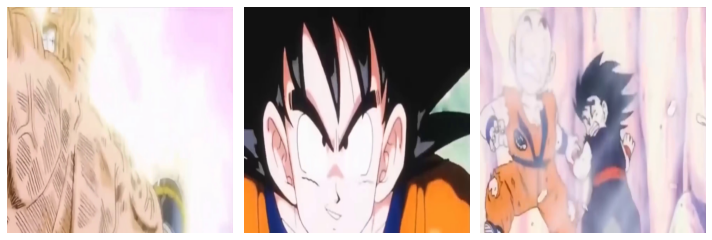

In [77]:
plot_img((10,10), [dbz_np_c[50], dbz_np_c[250] ,dbz_np_c[400]],
         ['', '', '', ''], (1, 3))

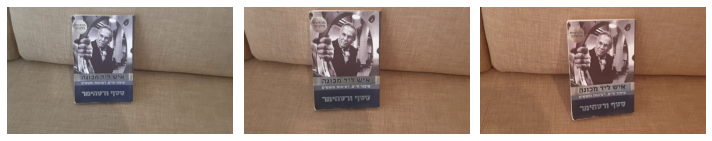

In [79]:
plot_img((10,10), [bv_np[50], bv_np[100] ,bv_np[150]],
         ['', '', '', ''], (1, 3))

In [ ]:
M_list = []
ref_steff =  create_ref('my_data/video/images/BV/0000.jpg', 500).copy()
for j,i in enumerate(bv_np,0):
    p1,p2 = orb_fun(i,ref_steff)
    M, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    M_list.append(M)
    if(j%10 == 0):
        path=os.path.join("my_data", "video", "images","BV", str(j).zfill(4)+".jpg")
        ref_steff =  create_ref(path, 500).copy()

In [ ]:
path = 'my_data/video/images/BV/' + '0000,jpg'

In [ ]:
# n = len(M_list)
# BOOK_DBZ =[]
# for j,i in enumerate(range(n),0):
#         BOOK_DBZ.append(warp2book(dbz_np_c[i+30], M_list[j], bv_np[i],'cubic','LAB').copy())

In [ ]:
# fig,ax = plt.subplots(2,2,figsize = (10,10))
# ax[0,0].imshow(BOOK_DBZ[0])
# ax[0,1].imshow(bv_np[210])
# ax[1,0].imshow(BOOK_DBZ[9])
# ax[1,1].imshow(bv_np[219])
# plt.show()

In [ ]:
# path_BV = os.path.join("my_data", "video", "images","vid_im")
# My_video = imageimport(path_BV).copy()
# fig,ax = plt.subplots(2,2,figsize = (10,10))
# ax[0,0].imshow(My_video[0])
# ax[0,1].imshow(My_video[210])
# ax[1,0].imshow(My_video[9])
# ax[1,1].imshow(My_video[219])
# plt.show()

# STYLE Transfer

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize),
    transforms.ToTensor()])

In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path_images_im = os.path.join("my_data", "video", "images","vid_im","0000.jpg")

In [ ]:
dbz_image = image_loader(path_images_im)

In [ ]:
Namek_style = image_loader(os.path.join("my_data", "video", "Namek.jpg"))

In [ ]:
assert Namek_style.size() == dbz_image.size(), \
    "we need to import style and content images of the same size"

def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

In [ ]:
plt.figure()
imshow(Namek_style, title='Namek')
plt.figure()
imshow(dbz_image, title='Video')


In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
input_img = dbz_image.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=150,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

In [ ]:
for i in range(278,303):
    fname = str(i).zfill(4)
    path_images_im = os.path.join("my_data", "video", "images","vid_im",fname+".jpg")
    print(path_images_im)
    try:
        dbz_image = image_loader(path_images_im)
        input_img = dbz_image.clone()
        output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                dbz_image, Namek_style, input_img)
        im_s(output, fname)
    except:
        continue

In [ ]:
def im_s(tensor, fname, output_path = os.path.join("my_data", "video", "images","style")):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(os.path.join(output_path, fname + ".jpg"))

In [ ]:
# image_seq_to_video(os.path.join("my_data", "video", "images","style"), './my_data/video.mp4', fps=30.0)